In [18]:
import pandas as pd
import json
import os
from collections import defaultdict 
from matplotlib import pyplot as plt 

In [19]:
def ns_to_s(e, name):
    if e[name] is not None:
        e[name] = e[name]  / 1000.0 / 1000.0 / 1000.0

def load_data(filename):
    name = os.path.basename(filename).split('.')[0]
    with open(filename) as f:
        entries = []
        for line in f.readlines():
            if line.startswith("{"):
                d = json.loads(line)
                e = {'bench': name, **d['conf'], **d['stats']}
                ns_to_s(e, 'correct_repair_ns')
                ns_to_s(e, 'minimal_repair_candidate_ns')
                
                entries.append(e)
    return entries
logs = ["sdram_w1.log", "sdram_w2.log", "c1.log", "i2c_k1.log"]

In [20]:
data = []
for log in logs:
    data += load_data(log)
table = pd.DataFrame(data)

In [21]:
table

,bench,past_k,future_k,window_size,offset,minimal_repair_candidate_ns,correct_repair_tries,correct_repair_ns
0,sdram_w1,0,0,1,0,NaN,NaN,NaN
1,sdram_w1,1,0,2,0,0.042085,NaN,NaN
2,sdram_w1,0,1,2,1,NaN,NaN,NaN
3,sdram_w1,1,1,3,1,0.047726,NaN,NaN
4,sdram_w1,0,2,3,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14470,i2c_k1,89,0,90,0,42.831376,2.0,50.828527
14471,i2c_k1,88,1,90,1,36.314133,2.0,43.827264
14472,i2c_k1,87,2,90,2,20.427675,3.0,24.940239
14473,i2c_k1,86,3,90,3,30.253631,2.0,33.752012


In [54]:
def load_time(filename):
    name = os.path.basename(filename).split('.')[0]
    with open(filename) as f:
        time_by_window_size = defaultdict(list)
        window_size_count = defaultdict(int)
        for line in f.readlines():
            if line.startswith("{"):
                d = json.loads(line)
                e = {'bench': name, **d['conf'], **d['stats']}
                window_size_count[e['window_size']] += 1
                if e['correct_repair_ns'] is None:
                    continue
                ns_to_s(e, 'correct_repair_ns')
                ns_to_s(e, 'minimal_repair_candidate_ns')
                time_by_window_size[e['window_size']].append(e['correct_repair_ns'])
    return time_by_window_size, window_size_count

In [55]:
def plot_window_size_vs_time(filename):
    time_by_window_size, window_size_count = load_time(filename)
    max_window_size = max(time_by_window_size.keys()) - 1 # make sure we do not look at incomplete data
    x = sorted(list(time_by_window_size.keys()))[:-1]
    y = [sum(time_by_window_size[w]) for w in x]
    print(f"min window size: {x[0]}, {len(time_by_window_size[x[0]])} / {window_size_count[x[0]]}")
    plt.plot(x, y)
    plt.title(filename)
    plt.xlabel("window size")
    plt.ylabel("average time (s)")
    plt.savefig(filename + ".png")
    plt.show()
    success_y = [float(len(time_by_window_size[w])) /window_size_count[w]  for w in x]
    

min window size: 5, 1 / 5


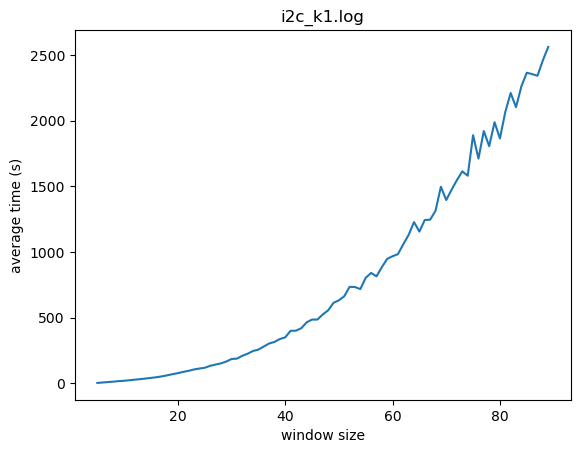

In [56]:
plot_window_size_vs_time('i2c_k1.log')

min window size: 4, 1 / 4


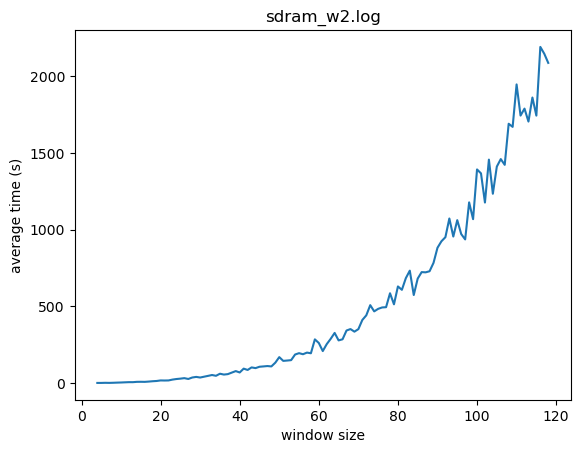

In [57]:
plot_window_size_vs_time('sdram_w2.log')

min window size: 4, 1 / 4


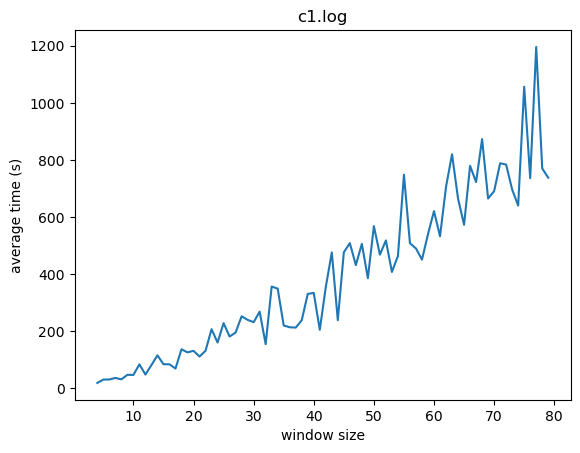

In [58]:
plot_window_size_vs_time('c1.log')